In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm

plt.style.use('grayscale')
plt.style.use('seaborn-whitegrid')
np.random.seed(0)

/Users/hiromu.nakamura/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
n_arms = 4

class Env(object):
  thetas = [0.1, 0.1, 0.2, 0.3]

  def react(arm):
    return 1 if np.random.random() < Env.thetas[arm] else 0

  def opt():
    return np.argmax(Env.thetas)

In [3]:
class OracleAgent(object):
  def __init__(self):
    self.arm = Env.opt()

  def get_arm(self):
    return self.arm

  def sample(self, arm, reward):
    pass

In [4]:
def sim(Agent, N=1000, T=1000, **kwargs):
  selected_arms = [[0 for _ in range(T)] for _ in range(N)]
  earned_rewards = [[0 for _ in range(T)] for _ in range(N)]

  for n in range(N):
    agent = Agent(**kwargs)
    for t in range(T):
      arm = agent.get_arm()
      reward = Env.react(arm)
      agent.sample(arm, reward)
      selected_arms[n][t] = arm
      earned_rewards[n][t] = reward
  return np.array(selected_arms), np.array(earned_rewards)

In [5]:
class UCBAgent(object):

  def __init__(self):
    self.counts = [0 for _ in range(n_arms)]
    self.values = [0 for _ in range(n_arms)]

  def calc_ucb(self, arm):
    ucb = self.values[arm]
    ucb += np.sqrt(np.log(sum(self.counts)) / (2 * self.counts[arm]))
    return ucb

  def get_arm(self):
    if 0 in self.counts:
      arm = self.counts.index(0)
    else:
      ucb = [self.calc_ucb(arm) for arm in range(n_arms)]
      arm = ucb.index(max(ucb))
    return arm

  def sample(self, arm, reward):
    self.counts[arm] = self.counts[arm] + 1
    self.values[arm] = (
        (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

Matplotlib is building the font cache; this may take a moment.


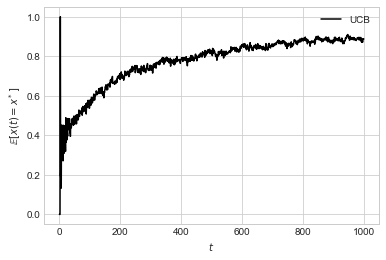

In [6]:
arms_ucb, rewards_ucb = sim(UCBAgent)

plt.plot(np.mean(arms_ucb == Env.opt(), axis=0), label='UCB')
# plt.plot(np.mean(arms_ts == Env.opt(), axis=0),
#           label='Thompson Sampling')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()